# Transform Effects on Angle Sequences

This notebook demonstrates how each data augmentation transform affects angle sequences.
We load cached feature data and visualize the before/after effects of each transform.

In [1]:
import os

import matplotlib.pyplot as plt
import torch

from feature_engineering.constants import (
    LEFT_ELBOW_ANGLE_IDX,
    RIGHT_ELBOW_ANGLE_IDX,
)
from feature_engineering.transforms import (
    RandomSequenceRepeat,
    RandomHorizontalFlipLandmarks,
    RandomNoise,
    RandomTimeWarp,
    RandomSequenceReverse,
    RandomScaling,
    RandomDropout,
)

## Load Sample Data

We'll load a cached feature file from the `.feature_cache` directory.

In [2]:
CACHE_DIR = ".feature_cache"
PLOTS_DIR = "plots"

cache_files = [f for f in os.listdir(CACHE_DIR) if f.endswith('.pt')]
print(f"Found {len(cache_files)} cached feature files")

sample_file = next((f for f in cache_files if f.startswith('3_')), cache_files[0])
sample_path = os.path.join(CACHE_DIR, sample_file)

result = torch.load(sample_path, weights_only=False)

angles = result.angle_sequence
density_map = result.density_map
label = int(sample_file.split('_')[0])

print(f"Loaded: {sample_file}")
print(f"Angles shape: {angles.shape}")
print(f"Density map shape: {density_map.shape}")
print(f"Label: {label}")

Found 77 cached feature files
Loaded: 3_kling_20251206_Text_to_Video_Generate_a_71_2.pt
Angles shape: torch.Size([151, 6])
Density map shape: torch.Size([151])
Label: 3


## Visualization Helper Functions

In [3]:
ANGLE_NAMES = [
    "Left Elbow",
    "Right Elbow", 
    "Left Shoulder",
    "Right Shoulder",
    "Left Body",
    "Right Body",
]


def plot_before_after(
    original_angles: torch.Tensor,
    transformed_angles: torch.Tensor,
    transform_name: str,
    save_path: str,
    angle_indices: list = None,
):
    """Plot angle sequences before and after a transform.
    
    Args:
        original_angles: Original angle tensor of shape (T, 6)
        transformed_angles: Transformed angle tensor of shape (T', 6)
        transform_name: Name of the transform for the title
        save_path: Path to save the figure
        angle_indices: List of angle indices to plot (default: left and right elbow)
    """
    if angle_indices is None:
        angle_indices = [LEFT_ELBOW_ANGLE_IDX, RIGHT_ELBOW_ANGLE_IDX]
    
    n_angles = len(angle_indices)
    fig, axes = plt.subplots(n_angles, 2, figsize=(14, 3 * n_angles))
    if n_angles == 1:
        axes = axes.reshape(1, 2)
    fig.suptitle(f"{transform_name}", fontsize=14, fontweight='bold')
    
    # Plot each angle
    for i, angle_idx in enumerate(angle_indices):
        # Original
        axes[i, 0].plot(original_angles[:, angle_idx].numpy(), 'b-', linewidth=1.5)
        axes[i, 0].set_title(f"Original - {ANGLE_NAMES[angle_idx]}")
        axes[i, 0].set_ylabel("Normalized Angle")
        axes[i, 0].set_ylim(0, 1)
        axes[i, 0].grid(True, alpha=0.3)
        
        # Transformed
        axes[i, 1].plot(transformed_angles[:, angle_idx].numpy(), 'r-', linewidth=1.5)
        axes[i, 1].set_title(f"Transformed - {ANGLE_NAMES[angle_idx]}")
        axes[i, 1].set_ylim(0, 1)
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()


def plot_overlay(
    original_angles: torch.Tensor,
    transformed_angles: torch.Tensor,
    transform_name: str,
    save_path: str,
    angle_indices: list = None,
):
    """Plot original and transformed angles overlaid on the same plot.
    
    Args:
        original_angles: Original angle tensor of shape (T, 6)
        transformed_angles: Transformed angle tensor of shape (T', 6)
        transform_name: Name of the transform for the title
        save_path: Path to save the figure
        angle_indices: List of angle indices to plot (default: left and right elbow)
    """
    if angle_indices is None:
        angle_indices = [LEFT_ELBOW_ANGLE_IDX, RIGHT_ELBOW_ANGLE_IDX]
    
    n_angles = len(angle_indices)
    fig, axes = plt.subplots(1, n_angles, figsize=(7 * n_angles, 4))
    if n_angles == 1:
        axes = [axes]
    
    fig.suptitle(f"{transform_name} - Overlay", fontsize=14, fontweight='bold')
    
    for i, angle_idx in enumerate(angle_indices):
        axes[i].plot(original_angles[:, angle_idx].numpy(), 'b-', linewidth=2, label='Original', alpha=0.7)
        axes[i].plot(transformed_angles[:, angle_idx].numpy(), 'r--', linewidth=2, label='Transformed', alpha=0.7)
        axes[i].set_title(ANGLE_NAMES[angle_idx])
        axes[i].set_xlabel("Frame")
        axes[i].set_ylabel("Normalized Angle")
        axes[i].set_ylim(0, 1)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()

## 1. RandomSequenceRepeat

Repeats the sequence to create training examples with higher counts.
This transform concatenates a sequence with itself one or more times.

Original:    151 frames, label=3
Transformed: 453 frames, label=9
Saved: plots/transform_sequence_repeat.png


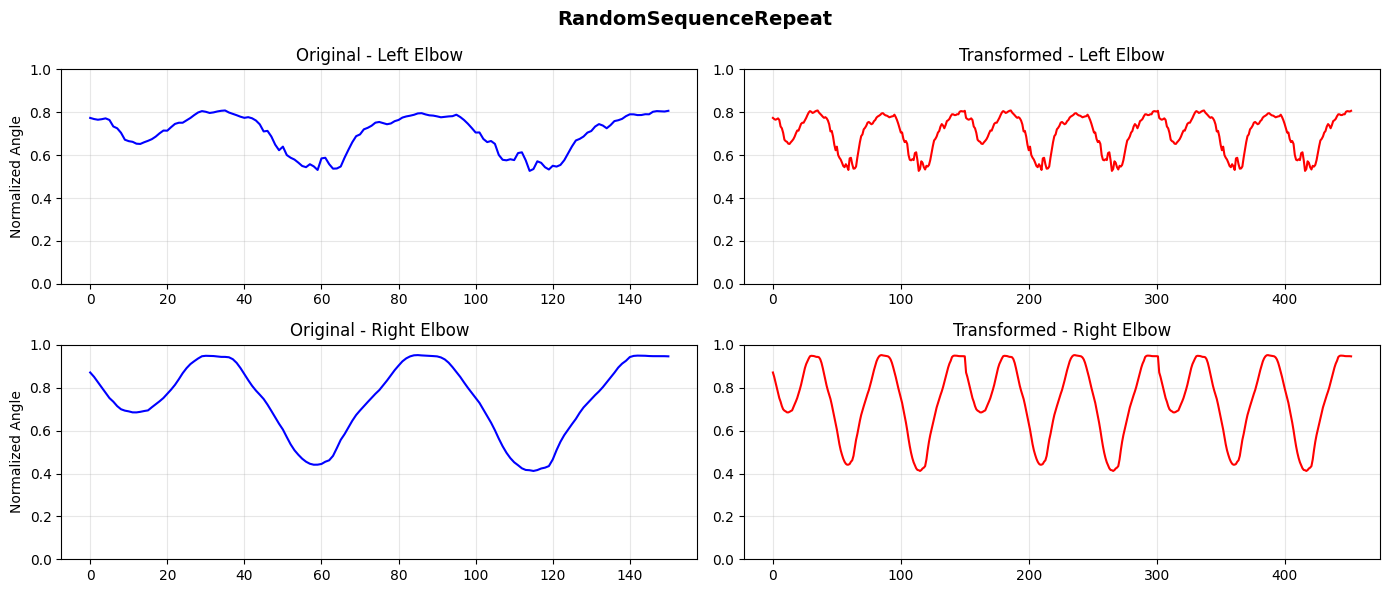

In [4]:
transform = RandomSequenceRepeat(p=1.0, max_count=10, max_repeat_factor=3)

torch.manual_seed(42)
transformed_angles, transformed_density, transformed_label = transform(
    angles.clone(), density_map.clone(), label
)

print(f"Original:    {angles.shape[0]} frames, label={label}")
print(f"Transformed: {transformed_angles.shape[0]} frames, label={transformed_label}")

plot_before_after(
    angles, transformed_angles,
    "RandomSequenceRepeat",
    os.path.join(PLOTS_DIR, "transform_sequence_repeat.png")
)

## 2. RandomHorizontalFlipLandmarks

Swaps left and right angle values to simulate a horizontal flip of the video.
This maintains anatomical consistency when mirroring the pose.

Original left elbow mean:  0.7020
Original right elbow mean: 0.7421
Transformed left elbow mean:  0.7421
Transformed right elbow mean: 0.7020
Saved: plots/transform_horizontal_flip.png


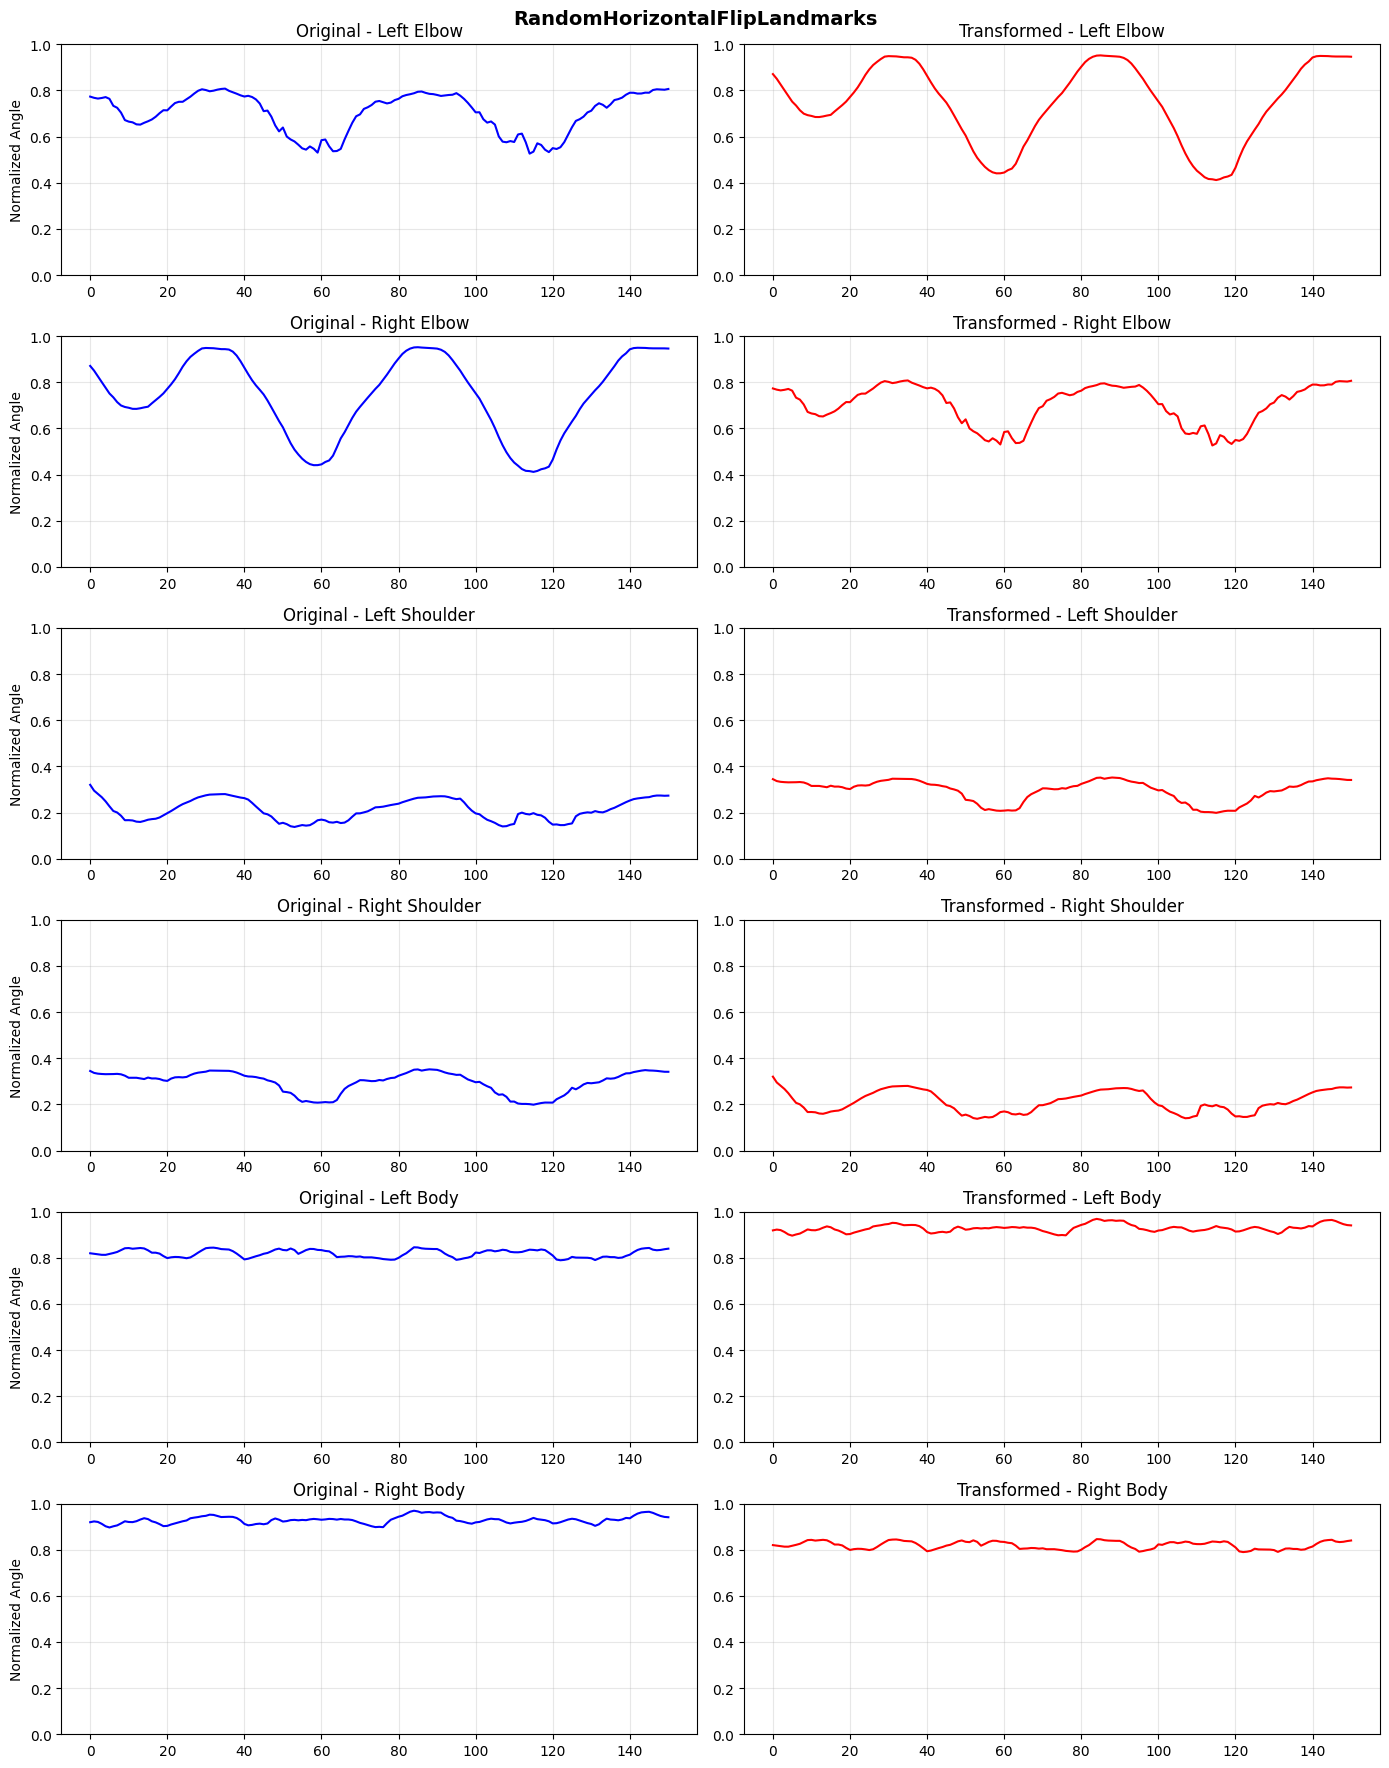

In [5]:
transform = RandomHorizontalFlipLandmarks(p=1.0)

transformed_angles, transformed_density, transformed_label = transform(
    angles.clone(), density_map.clone(), label
)

print(f"Original left elbow mean:  {angles[:, LEFT_ELBOW_ANGLE_IDX].mean():.4f}")
print(f"Original right elbow mean: {angles[:, RIGHT_ELBOW_ANGLE_IDX].mean():.4f}")
print(f"Transformed left elbow mean:  {transformed_angles[:, LEFT_ELBOW_ANGLE_IDX].mean():.4f}")
print(f"Transformed right elbow mean: {transformed_angles[:, RIGHT_ELBOW_ANGLE_IDX].mean():.4f}")

# Show all 6 angles to visualize the swap
plot_before_after(
    angles, transformed_angles,
    "RandomHorizontalFlipLandmarks",
    os.path.join(PLOTS_DIR, "transform_horizontal_flip.png"),
    angle_indices=list(range(6))  # All angles
)

## 3. RandomNoise

Adds Gaussian noise to the joint angles to simulate pose detection noise.
Makes the model more robust to imprecise pose detection.

Saved: plots/transform_noise_overlay.png


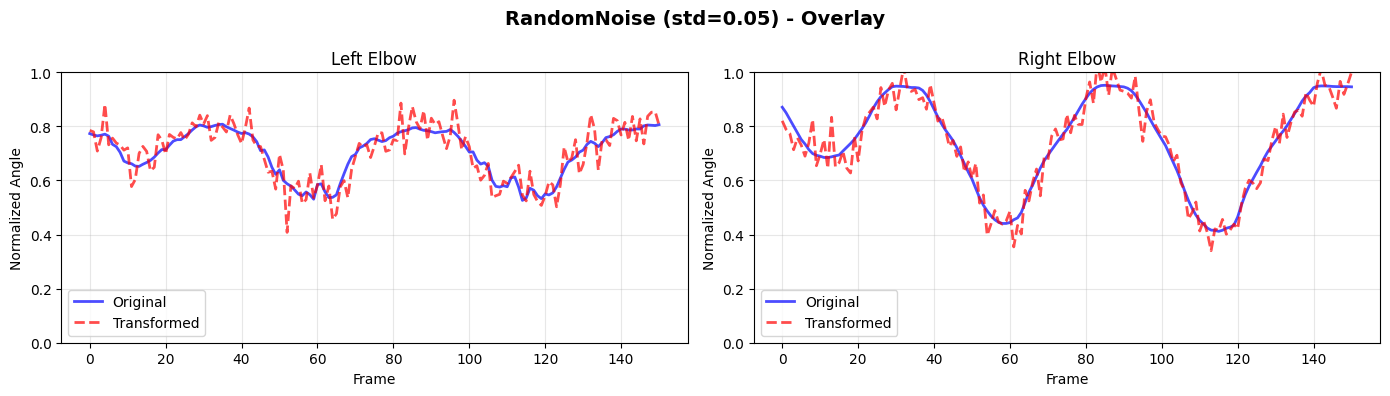

Saved: plots/transform_noise.png


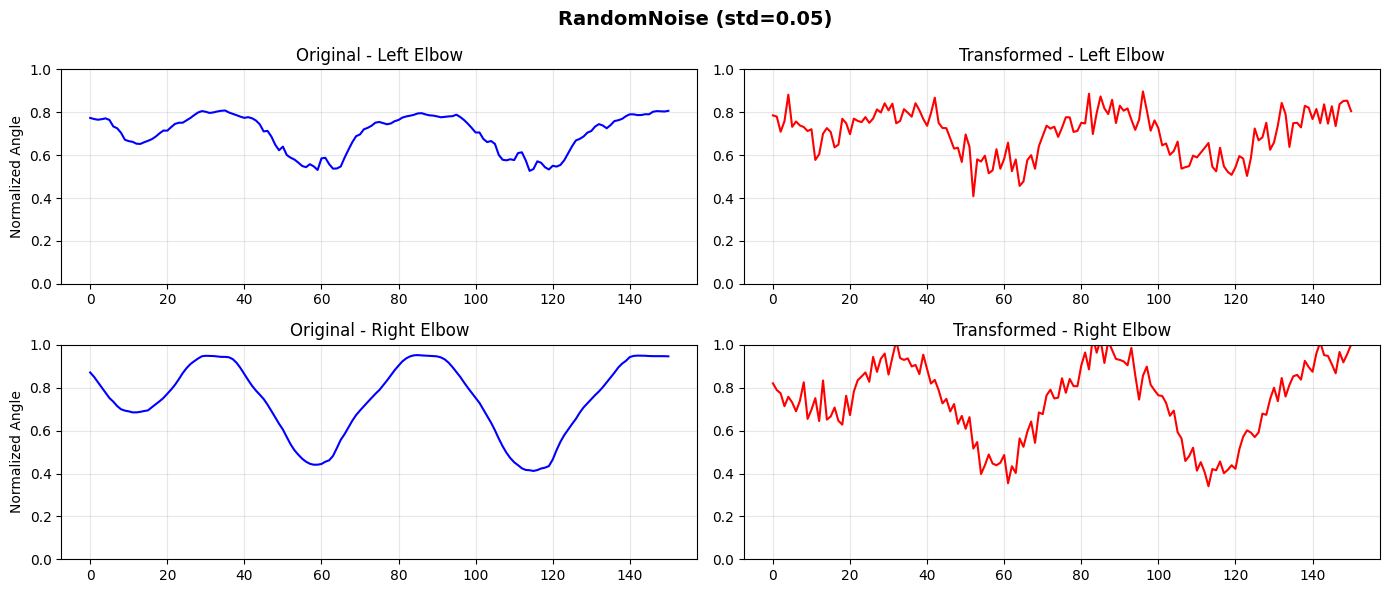

In [6]:
# Use a larger std for more visible effect
transform = RandomNoise(p=1.0, std=0.05)

transformed_angles, transformed_density, transformed_label = transform(
    angles.clone(), density_map.clone(), label
)

plot_overlay(
    angles, transformed_angles,
    "RandomNoise (std=0.05)",
    os.path.join(PLOTS_DIR, "transform_noise_overlay.png")
)

plot_before_after(
    angles, transformed_angles,
    "RandomNoise (std=0.05)",
    os.path.join(PLOTS_DIR, "transform_noise.png")
)

## 4. RandomTimeWarp

Resamples the temporal sequence to a new length, simulating videos 
recorded at different speeds or exercises performed at varying paces.

Original:    151 frames
Transformed: 107 frames (scale ≈ 0.7)
Saved: plots/transform_timewarp_compressed.png


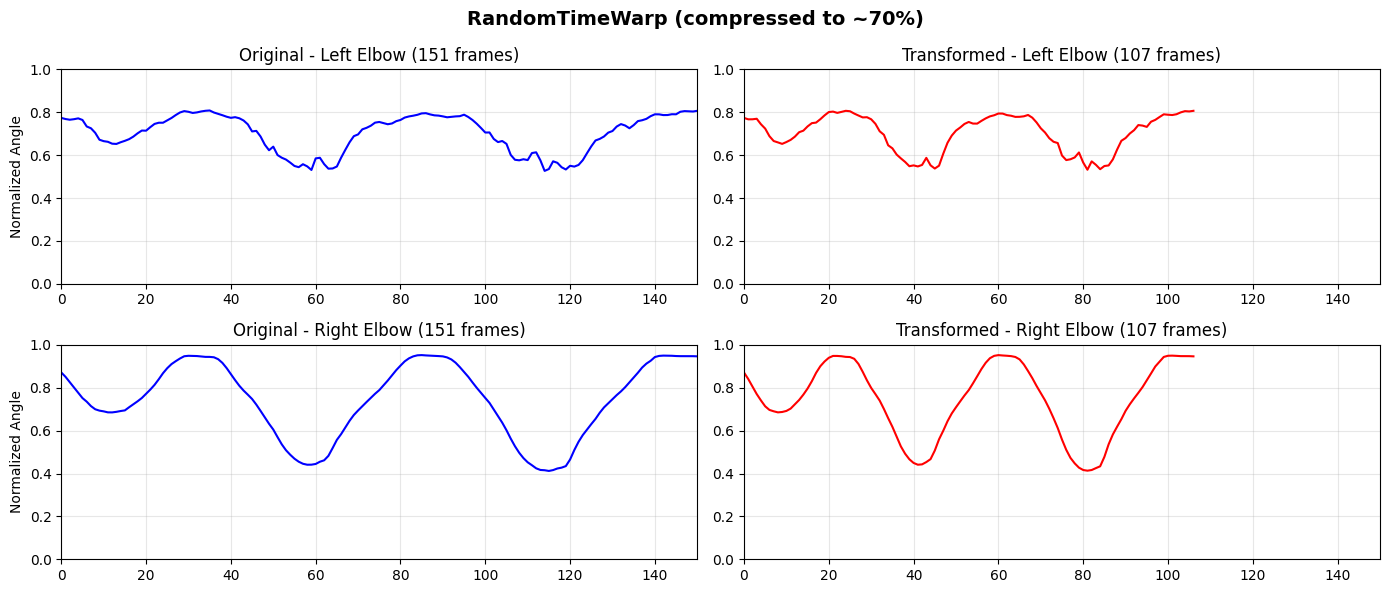

Stretched:   203 frames (scale ≈ 1.3)
Saved: plots/transform_timewarp_stretched.png


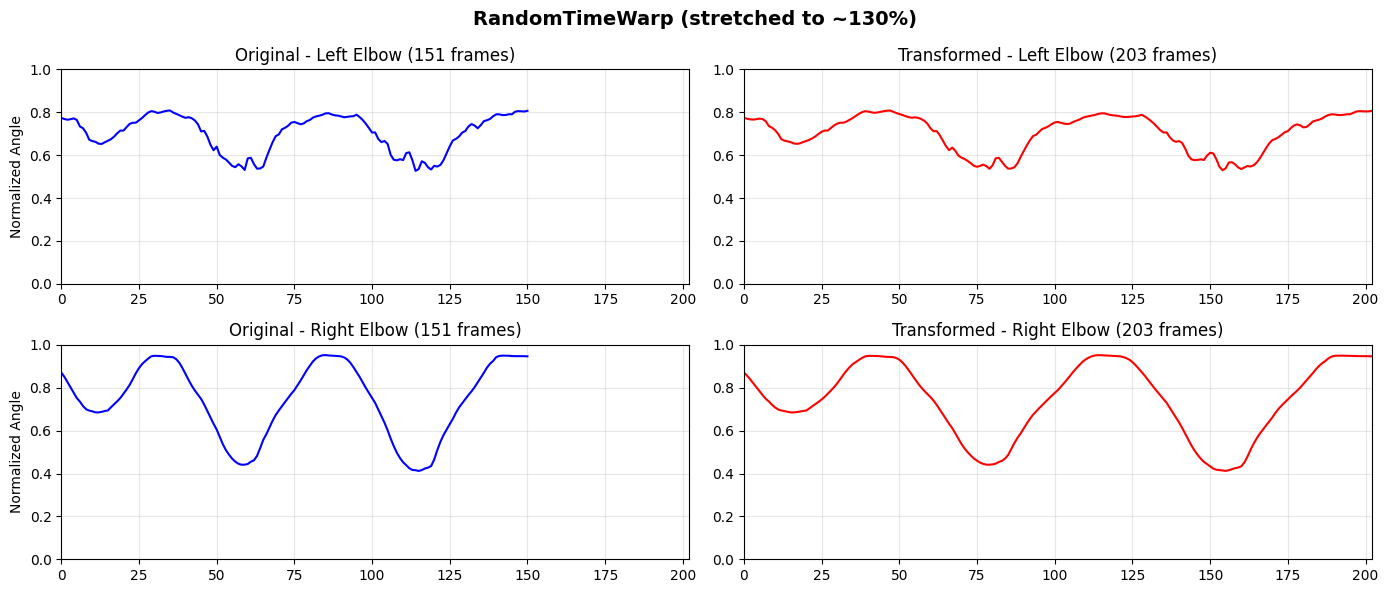

In [7]:
# Force a specific scale range for visible effect
transform = RandomTimeWarp(p=1.0, scale_range=(0.7, 0.75))  # Compress by ~30%

transformed_angles, transformed_density, transformed_label = transform(
    angles.clone(), density_map.clone(), label
)

print(f"Original:    {angles.shape[0]} frames")
print(f"Transformed: {transformed_angles.shape[0]} frames (scale ≈ 0.7)")

# Custom plot to show compression effect
angle_indices = [LEFT_ELBOW_ANGLE_IDX, RIGHT_ELBOW_ANGLE_IDX]
n_angles = len(angle_indices)
fig, axes = plt.subplots(n_angles, 2, figsize=(14, 3 * n_angles))
if n_angles == 1:
    axes = axes.reshape(1, 2)
fig.suptitle("RandomTimeWarp (compressed to ~70%)", fontsize=14, fontweight='bold')

orig_len = angles.shape[0]
trans_len = transformed_angles.shape[0]

for i, angle_idx in enumerate(angle_indices):
    # Original
    axes[i, 0].plot(angles[:, angle_idx].numpy(), 'b-', linewidth=1.5)
    axes[i, 0].set_title(f"Original - {ANGLE_NAMES[angle_idx]} ({orig_len} frames)")
    axes[i, 0].set_ylabel("Normalized Angle")
    axes[i, 0].set_ylim(0, 1)
    axes[i, 0].set_xlim(0, orig_len - 1)
    axes[i, 0].grid(True, alpha=0.3)
    
    # Transformed - plot at natural indices but with same xlim to show compression
    axes[i, 1].plot(transformed_angles[:, angle_idx].numpy(), 'r-', linewidth=1.5)
    axes[i, 1].set_title(f"Transformed - {ANGLE_NAMES[angle_idx]} ({trans_len} frames)")
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_xlim(0, orig_len - 1)
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
compressed_path = os.path.join(PLOTS_DIR, "transform_timewarp_compressed.png")
plt.savefig(compressed_path, dpi=150, bbox_inches='tight')
print(f"Saved: {compressed_path}")
plt.show()

# Show stretched version
transform_stretch = RandomTimeWarp(p=1.0, scale_range=(1.3, 1.35))

transformed_angles_stretched, transformed_density_stretched, _ = transform_stretch(
    angles.clone(), density_map.clone(), label
)

print(f"Stretched:   {transformed_angles_stretched.shape[0]} frames (scale ≈ 1.3)")

# Custom plot to show stretch effect with same x-axis width
stretch_orig_len = angles.shape[0]
stretch_trans_len = transformed_angles_stretched.shape[0]

fig, axes = plt.subplots(n_angles, 2, figsize=(14, 3 * n_angles))
if n_angles == 1:
    axes = axes.reshape(1, 2)
fig.suptitle("RandomTimeWarp (stretched to ~130%)", fontsize=14, fontweight='bold')

for i, angle_idx in enumerate(angle_indices):
    # Original - plot at natural indices but with same xlim to show stretch
    axes[i, 0].plot(angles[:, angle_idx].numpy(), 'b-', linewidth=1.5)
    axes[i, 0].set_title(f"Original - {ANGLE_NAMES[angle_idx]} ({stretch_orig_len} frames)")
    axes[i, 0].set_ylabel("Normalized Angle")
    axes[i, 0].set_ylim(0, 1)
    axes[i, 0].set_xlim(0, stretch_trans_len - 1) # Same xlim as transformed to show stretch
    axes[i, 0].grid(True, alpha=0.3)
    
    # Transformed
    axes[i, 1].plot(transformed_angles_stretched[:, angle_idx].numpy(), 'r-', linewidth=1.5)
    axes[i, 1].set_title(f"Transformed - {ANGLE_NAMES[angle_idx]} ({stretch_trans_len} frames)")
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_xlim(0, stretch_trans_len - 1)
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
stretched_path = os.path.join(PLOTS_DIR, "transform_timewarp_stretched.png")
plt.savefig(stretched_path, dpi=150, bbox_inches='tight')
print(f"Saved: {stretched_path}")
plt.show()

## 5. RandomSequenceReverse

Reverses the temporal order of the sequence. A push-up in reverse 
(ascend then descend) is still a valid motion pattern.

Saved: plots/transform_reverse.png


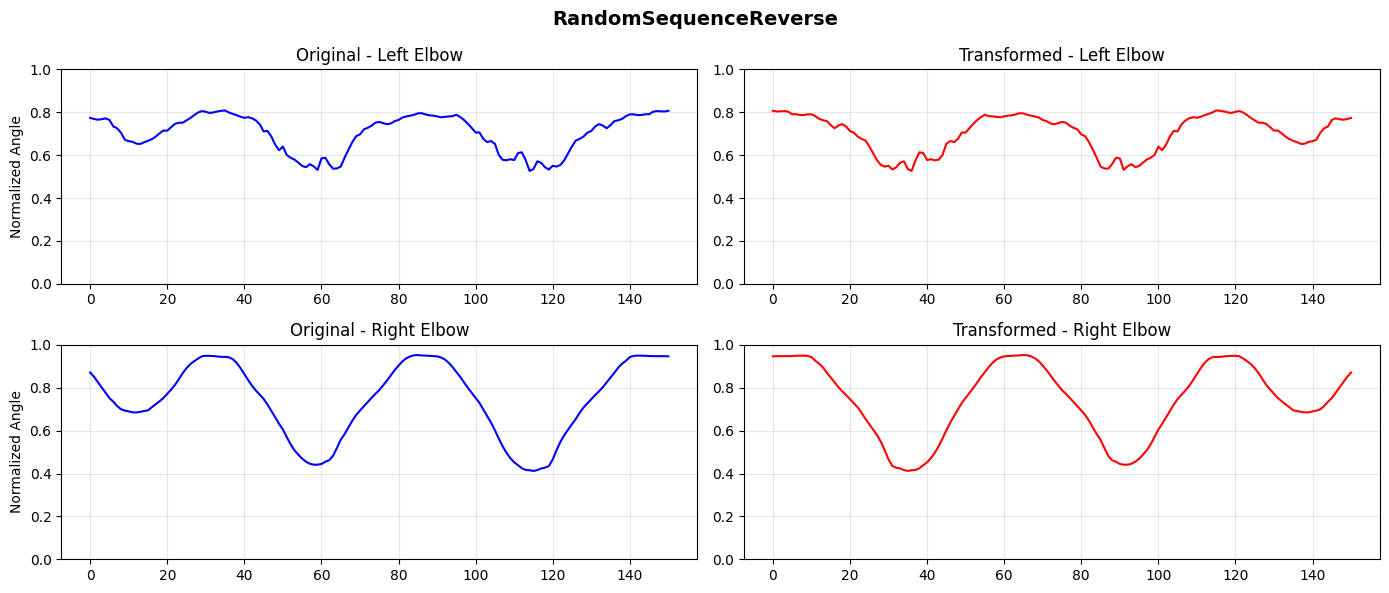

Saved: plots/transform_reverse_overlay.png


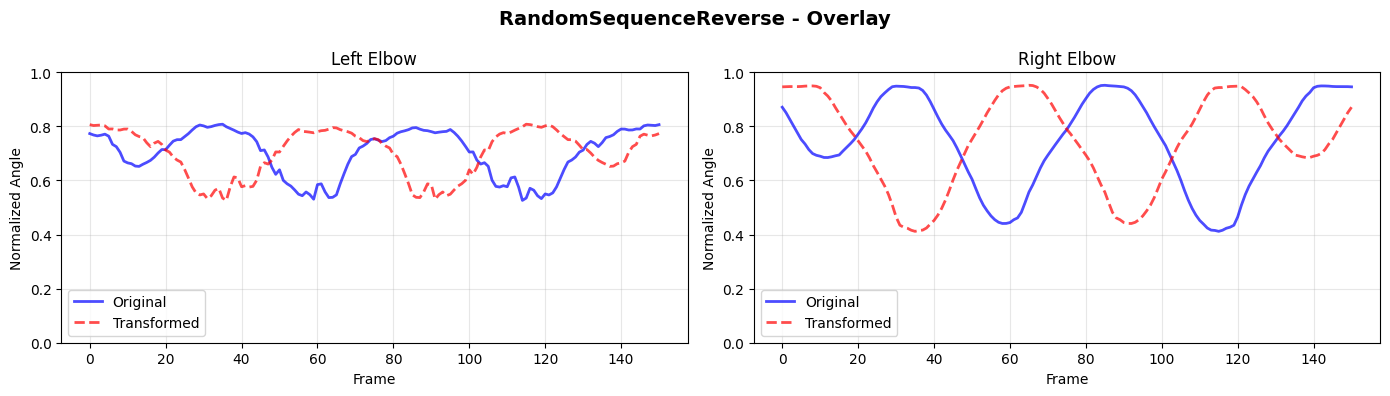

In [8]:
transform = RandomSequenceReverse(p=1.0)

transformed_angles, transformed_density, transformed_label = transform(
    angles.clone(), density_map.clone(), label
)

plot_before_after(
    angles, transformed_angles,
    "RandomSequenceReverse",
    os.path.join(PLOTS_DIR, "transform_reverse.png")
)

plot_overlay(
    angles, transformed_angles,
    "RandomSequenceReverse",
    os.path.join(PLOTS_DIR, "transform_reverse_overlay.png")
)

## 6. RandomScaling

Scales the angle values by a multiplicative factor, simulating variations 
in range of motion. Results are clamped to [0, 1].

Saved: plots/transform_scaling.png


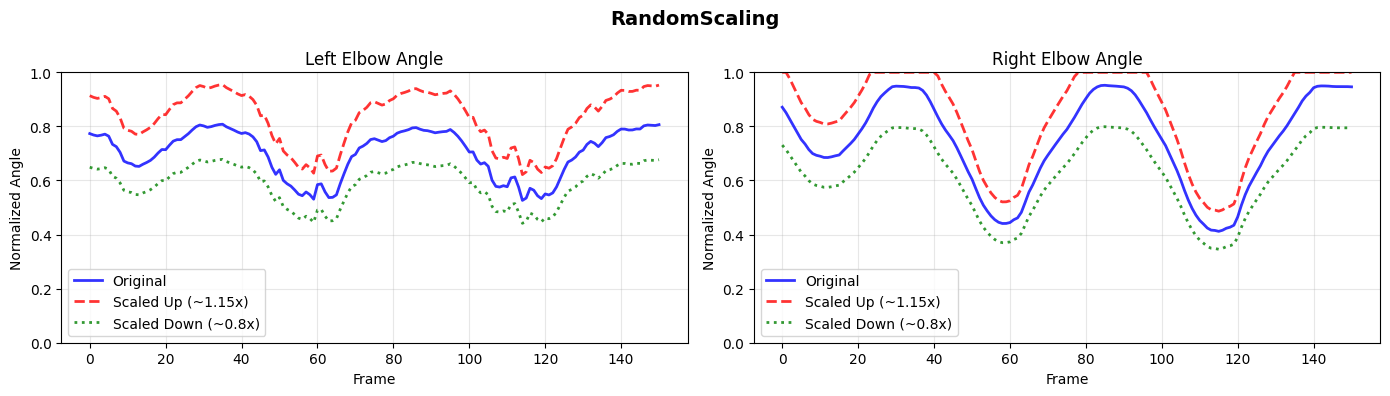

In [9]:
transform_up = RandomScaling(p=1.0, scale_range=(1.15, 1.2))
transform_down = RandomScaling(p=1.0, scale_range=(0.8, 0.85))

scaled_up, _, _ = transform_up(angles.clone(), density_map.clone(), label)

scaled_down, _, _ = transform_down(angles.clone(), density_map.clone(), label)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("RandomScaling", fontsize=14, fontweight='bold')

# Left elbow comparison
ax = axes[0]
ax.plot(angles[:, LEFT_ELBOW_ANGLE_IDX].numpy(), 'b-', linewidth=2, label='Original', alpha=0.8)
ax.plot(scaled_up[:, LEFT_ELBOW_ANGLE_IDX].numpy(), 'r--', linewidth=2, label='Scaled Up (~1.15x)', alpha=0.8)
ax.plot(scaled_down[:, LEFT_ELBOW_ANGLE_IDX].numpy(), 'g:', linewidth=2, label='Scaled Down (~0.8x)', alpha=0.8)
ax.set_title("Left Elbow Angle")
ax.set_xlabel("Frame")
ax.set_ylabel("Normalized Angle")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

# Right elbow comparison
ax = axes[1]
ax.plot(angles[:, RIGHT_ELBOW_ANGLE_IDX].numpy(), 'b-', linewidth=2, label='Original', alpha=0.8)
ax.plot(scaled_up[:, RIGHT_ELBOW_ANGLE_IDX].numpy(), 'r--', linewidth=2, label='Scaled Up (~1.15x)', alpha=0.8)
ax.plot(scaled_down[:, RIGHT_ELBOW_ANGLE_IDX].numpy(), 'g:', linewidth=2, label='Scaled Down (~0.8x)', alpha=0.8)
ax.set_title("Right Elbow Angle")
ax.set_xlabel("Frame")
ax.set_ylabel("Normalized Angle")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
scaling_path = os.path.join(PLOTS_DIR, "transform_scaling.png")
plt.savefig(scaling_path, dpi=150, bbox_inches='tight')
print(f"Saved: {scaling_path}")
plt.show()

## 7. RandomDropout

Randomly zeros out individual angle values to simulate pose estimation failures
(occlusion, motion blur, low confidence detections). Makes the model robust to
incomplete sequences.

Original zeros: 0
Transformed zeros: 128
Dropped values: 128 (14.1% of total)
Saved: plots/transform_dropout_overlay.png


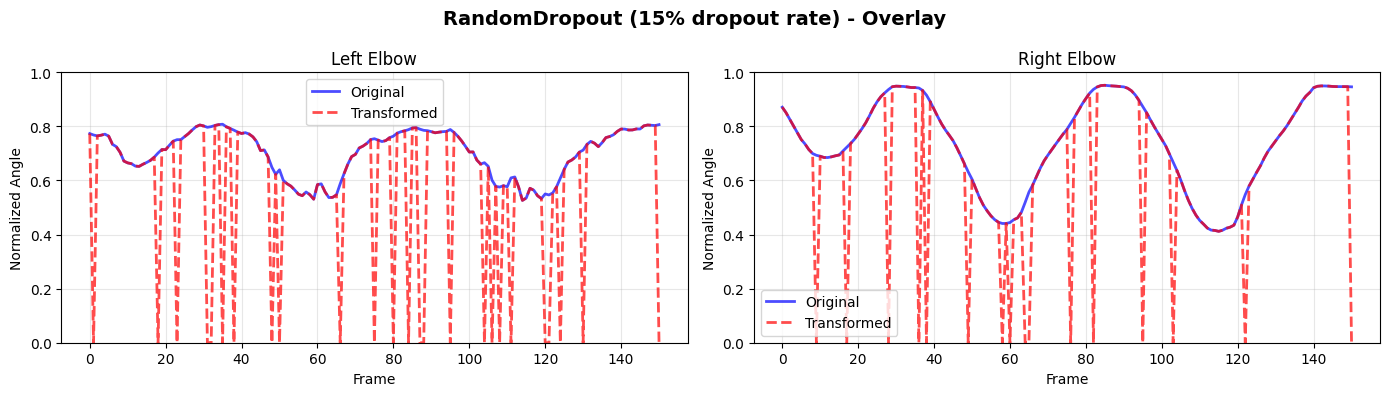

Saved: plots/transform_dropout.png


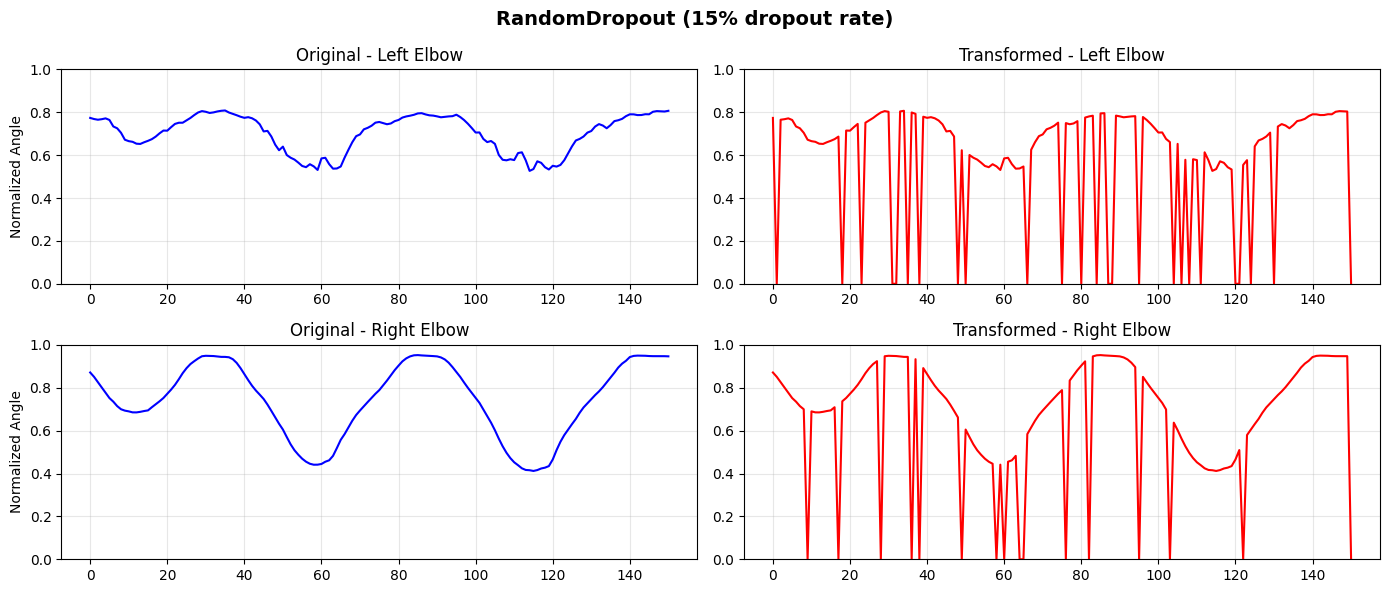

In [10]:
# Use higher dropout rate for visibility
transform = RandomDropout(p=1.0, dropout_rate=0.15)

transformed_angles, transformed_density, transformed_label = transform(
    angles.clone(), density_map.clone(), label
)

original_zeros = (angles == 0).sum().item()
transformed_zeros = (transformed_angles == 0).sum().item()
print(f"Original zeros: {original_zeros}")
print(f"Transformed zeros: {transformed_zeros}")
print(f"Dropped values: {transformed_zeros - original_zeros} ({(transformed_zeros - original_zeros) / angles.numel() * 100:.1f}% of total)")

plot_overlay(
    angles, transformed_angles,
    "RandomDropout (15% dropout rate)",
    os.path.join(PLOTS_DIR, "transform_dropout_overlay.png")
)

plot_before_after(
    angles, transformed_angles,
    "RandomDropout (15% dropout rate)",
    os.path.join(PLOTS_DIR, "transform_dropout.png")
)